In [1]:
# Import libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import random


In [2]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
# Set each environment variable to a notebook variable of the same name
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

In [4]:
# Create your Alpaca API REST object by calling Alpaca's tradeapi.REST function
# Set the parameters to your alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [5]:
# Gather portfolio preferences from user

risk_score = input("""What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
""")

preference_equity = input("""What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
""")


preference_fixed_income = input("""What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
""")


time_period = input("""What's your preferred time duration for investment? Enter a number to indicate the number of years.
""")


investment_value = input("""What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
""")

risk_score = int(risk_score)
preference_equity = int(preference_equity)
preference_fixed_income = int(preference_fixed_income)
time_period = int(time_period)
investment_value = int(investment_value)

What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
 5
What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
 1
What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
 2
What's your preferred time duration for investment? Enter a number to indicate the number of years.
 5
What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
 10000


In [6]:
# Create the list for the required tickers

# equity
tickers_equity_type1 = ["DIA", "DVY", "VNQ"]#dividend income
tickers_equity_type2 = ["QQQ", "VBK", "ARKK"]#capital growth
tickers_equity_type3 = ["SPY", "VXF", "IWM"]#balanced

# income
tickers_income_type1 = ["LQD"]#higher risk
tickers_income_type2 = ["IEI"]#higher quality
tickers_income_type3 = ["AGG"]#mixed

In [7]:
# Risk score needs to be converted to asset weights

weight_risk = risk_score/10 
weight_fixed = 1 - weight_risk 

        
    
# Do we need the below code??????????????????

# equity_investment = investment_value * weight_risk ($700)
# DIA = (1/3)* equity_investment
# DVY = (1/3)* equity_investment
# VNQ = (1/3)* equity_investment


# income_investment = investment_value * weight_fixed ($300)

In [8]:
# Assigns an empty list for tickers to be used for equity. If statement from user input determines how list is populated.

equity_tickers = []

if preference_equity == 1:
    equity_tickers = tickers_equity_type1
    
elif preference_equity == 2:
    equity_tickers = tickers_equity_type2
    
elif preference_equity == 3:
    equity_tickers = tickers_equity_type3

else:
    print("You did not enter a valid equity preference. Please try again.")

In [9]:
# Assigns an empty list for tickers to be used for fixed income. If statement from user input determines how list is populated.

fixed_income_tickers = []

if preference_fixed_income == 1:
    fixed_income_tickers = tickers_income_type1
    
elif preference_fixed_income == 2:
    fixed_income_tickers = tickers_income_type2
    
elif preference_fixed_income == 3:
    fixed_income_tickers = tickers_income_type3

else:
    print("You did not enter a valid equity preference. Please try again.")

In [10]:
tickers = equity_tickers + fixed_income_tickers
tickers

['DIA', 'DVY', 'VNQ', 'IEI']

In [11]:
# Determines weights to be applied to each ETF in the portfolio. For this analysis, assumes equity ETFs will be equal weighted.

weight_equity_1 = weight_risk / 3
weight_equity_2 = weight_risk /3
weight_equity_3 = weight_risk / 3
weight_fixed = 1 - weight_equity_1 - weight_equity_2 - weight_equity_3

weights = [weight_equity_1, weight_equity_2, weight_equity_3, weight_fixed]
weights

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.5000000000000001]

In [12]:
# Places portfolio tickers and weights into a dataframe and sorts alphabetically in order to run API call for ticker data

portfolio_df = pd.DataFrame({'tickers': tickers, 'weights': weights})
portfolio_df = portfolio_df.sort_values('tickers')
portfolio_df

,tickers,weights
0,DIA,0.166667
1,DVY,0.166667
3,IEI,0.500000
2,VNQ,0.166667


In [13]:
# recreates tickers list, this time in alphabetical order
tickers = portfolio_df['tickers'].tolist()
tickers

['DIA', 'DVY', 'IEI', 'VNQ']

In [14]:
# recreates weights list, this time, in the same order as the new sorted tickers list
weights = portfolio_df['weights'].tolist()
weights

[0.16666666666666666,
 0.16666666666666666,
 0.5000000000000001,
 0.16666666666666666]

In [15]:
# sets number of trading days for the simulation (time horizon of the investment)
num_trading_days = 252 * time_period

In [16]:
# Set the values for start_date and end_date using the pd.Timestamp function
# Inside the function set the date parameter to the prior business day 
# The start and end data should be 2017-05-01 to 2020-05-01
# Set the parameter tz to "America/New_York", 
# Set this all to the ISO format by calling the isoformat function 
start_date = pd.Timestamp("2018-12-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

In [17]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [18]:
# Use the Alpaca get_barset function to gather the price information for each ticker
# Include the function parameters: tickers, timeframe, start, end, and limit
# Be sure to call the df property to ensure that the returned information is set as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Review the first five rows of the resulting DataFrame 
prices_df.head()

DIA                                        DVY  \
                             open    high      low     close   volume   open   
time                                                                           
2018-12-31 00:00:00-05:00  232.33  233.22  231.050  231.7700  4600042  89.06   
2019-01-02 00:00:00-05:00  229.27  234.00  229.140  232.9800  4949729  88.29   
2019-01-03 00:00:00-05:00  231.25  231.42  226.621  227.1900  6864028  88.80   
2019-01-04 00:00:00-05:00  230.00  235.18  229.730  234.2401  6976907  88.83   
2019-01-07 00:00:00-05:00  234.84  236.88  232.951  235.3900  3873356  90.41   

                                                                   IEI  \
                              high      low   close     volume    open   
time                                                                     
2018-12-31 00:00:00-05:00  89.3099  88.3000  88.950  2673934.0  121.14   
2019-01-02 00:00:00-05:00  89.3300  87.8700  88.970  1164455.0  121.52   
2019-01-03 00:00:00-05:00  89.1800  87.9100  88.280   995745.0  121.62   
2019-01-04 00:00:00-05:00  90.4499  88.4201  90.350  1590662.0  121.70   
2019-01-07 00:00:00-05:00  91.5600  89.9500  90.905  1899922.0  121.67   

                                                                   VNQ  \
                             high       low    close     volume   open   
time                                                                     
2018-12-31 00:00:00-05:00  121.51  121.0900  121.455  1515989.0  74.31   
2019-01-02 00:00:00-05:00  121.56  121.4100  121.560  1303584.0  73.56   
2019-01-03 00:00:00-05:00  122.29  121.6000  122.240   562954.0  72.77   
2019-01-04 00:00:00-05:00  121.74  121.5200  121.575   616288.0  73.74   
2019-01-07 00:00:00-05:00  121.72  121.3233  121.335   749787.0  74.60   

                                                             
                              high    low   close    volume  
time                                                         
2018-12-31 00:00:00-05:00  74.7200  73.30  74.405  15320211  
2019-01-02 00:00:00-05:00  73.7000  72.53  72.880  10872410  
2019-01-03 00:00:00-05:00  74.5700  72.71  73.430   9963138  
2019-01-04 00:00:00-05:00  75.0200  73.30  74.330   7585079  
2019-01-07 00:00:00-05:00  75.6062  74.40  75.045   7502420

In [19]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
# Use an even weight of .33 across all 3 stocks
MC_even_weight = MCSimulation(
    portfolio_data = prices_df,
    weights = weights,
    num_simulation = 500,
    num_trading_days = num_trading_days
)

# Printing the first five rows of the simulation input data
MC_even_weight.portfolio_data.head()

DIA                                      \
                             open    high      low     close   volume   
time                                                                    
2018-12-31 00:00:00-05:00  232.33  233.22  231.050  231.7700  4600042   
2019-01-02 00:00:00-05:00  229.27  234.00  229.140  232.9800  4949729   
2019-01-03 00:00:00-05:00  231.25  231.42  226.621  227.1900  6864028   
2019-01-04 00:00:00-05:00  230.00  235.18  229.730  234.2401  6976907   
2019-01-07 00:00:00-05:00  234.84  236.88  232.951  235.3900  3873356   

                                          DVY                            ...  \
                          daily_return   open     high      low   close  ...   
time                                                                     ...   
2018-12-31 00:00:00-05:00          NaN  89.06  89.3099  88.3000  88.950  ...   
2019-01-02 00:00:00-05:00     0.005221  88.29  89.3300  87.8700  88.970  ...   
2019-01-03 00:00:00-05:00    -0.024852  88.80  89.1800  87.9100  88.280  ...   
2019-01-04 00:00:00-05:00     0.031032  88.83  90.4499  88.4201  90.350  ...   
2019-01-07 00:00:00-05:00     0.004909  90.41  91.5600  89.9500  90.905  ...   

                                IEI                                     VNQ  \
                                low    close     volume daily_return   open   
time                                                                          
2018-12-31 00:00:00-05:00  121.0900  121.455  1515989.0          NaN  74.31   
2019-01-02 00:00:00-05:00  121.4100  121.560  1303584.0     0.000865  73.56   
2019-01-03 00:00:00-05:00  121.6000  122.240   562954.0     0.005594  72.77   
2019-01-04 00:00:00-05:00  121.5200  121.575   616288.0    -0.005440  73.74   
2019-01-07 00:00:00-05:00  121.3233  121.335   749787.0    -0.001974  74.60   

                                                                          
                              high    low   close    volume daily_return  
time                                                                      
2018-12-31 00:00:00-05:00  74.7200  73.30  74.405  15320211          NaN  
2019-01-02 00:00:00-05:00  73.7000  72.53  72.880  10872410    -0.020496  
2019-01-03 00:00:00-05:00  74.5700  72.71  73.430   9963138     0.007547  
2019-01-04 00:00:00-05:00  75.0200  73.30  74.330   7585079     0.012257  
2019-01-07 00:00:00-05:00  75.6062  74.40  75.045   7502420     0.009619  

[5 rows x 24 columns]

In [20]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
# Create a new variable for the simulation above
sim_df = MC_even_weight.calc_cumulative_return()
sim_df

C:\Users\mwoji\FinTech-Workspace\Projects\portfolio_optimizer\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998080,0.996820,0.990602,1.007497,1.001101,1.002171,1.002346,0.998115,1.010095,0.998448,...,0.989699,1.001437,1.005300,0.995096,0.998899,0.995157,0.998312,1.002588,0.999111,0.998458
2,1.002352,0.994257,0.990763,1.006501,0.995476,0.992707,1.000899,0.995232,1.011102,1.001775,...,0.992657,1.003979,1.008125,0.998195,1.005416,0.991053,1.003410,0.995735,1.001809,1.001694
3,1.000710,0.989630,0.988804,1.004617,0.998095,0.991475,1.002703,0.990707,1.019991,1.009296,...,0.989053,1.009251,1.009412,1.000311,1.007072,0.997586,1.006506,0.999472,0.999519,1.004803
4,1.001593,0.992109,0.990120,1.010571,0.998429,0.994204,1.001511,0.992455,1.016450,1.009042,...,0.986373,1.007101,1.013150,0.998825,1.012917,1.007123,1.010465,1.004432,1.002734,1.001294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.674740,1.974561,1.264014,1.626171,1.263149,1.790330,1.662141,1.450114,1.813705,2.281638,...,1.447805,1.152005,1.196863,1.647098,1.644368,1.640555,1.806505,2.127570,1.560706,1.672537
1257,1.685591,1.976240,1.257442,1.620552,1.253607,1.800584,1.649592,1.454078,1.823035,2.285129,...,1.457133,1.150315,1.192207,1.652942,1.633535,1.638602,1.794851,2.136125,1.555811,1.670091
1258,1.691518,1.976910,1.255771,1.624265,1.241753,1.805257,1.649333,1.456713,1.822832,2.274294,...,1.454975,1.152243,1.195407,1.655632,1.639749,1.646310,1.786008,2.122816,1.546165,1.674082
1259,1.691122,1.994356,1.249746,1.624956,1.245730,1.806037,1.628755,1.458254,1.833200,2.287149,...,1.450932,1.147442,1.197730,1.638792,1.623407,1.651844,1.791126,2.101834,1.540108,1.677482


In [21]:
# Computes and returns a dataframe for daily price returns of each simulation for each trading day
shift_df = sim_df.shift(-1)
returns_df = (shift_df - sim_df) / sim_df
returns_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.001920,-0.003180,-0.009398,0.007497,0.001101,0.002171,0.002346,-0.001885,0.010095,-0.001552,...,-0.010301,0.001437,0.005300,-0.004904,-0.001101,-0.004843,-0.001688,0.002588,-0.000889,-0.001542
1,0.004281,-0.002572,0.000163,-0.000988,-0.005619,-0.009444,-0.001443,-0.002889,0.000997,0.003332,...,0.002989,0.002539,0.002811,0.003114,0.006524,-0.004124,0.005106,-0.006835,0.002700,0.003242
2,-0.001638,-0.004653,-0.001977,-0.001871,0.002630,-0.001240,0.001803,-0.004546,0.008792,0.007508,...,-0.003631,0.005251,0.001276,0.002120,0.001647,0.006593,0.003085,0.003753,-0.002286,0.003103
3,0.000882,0.002504,0.001331,0.005926,0.000335,0.002752,-0.001189,0.001764,-0.003472,-0.000252,...,-0.002709,-0.002131,0.003703,-0.001486,0.005805,0.009560,0.003934,0.004962,0.003216,-0.003491
4,-0.000251,-0.002360,0.004534,0.001047,0.001897,-0.005373,-0.003664,0.003105,0.006643,-0.000059,...,0.001977,0.004251,0.003845,-0.007147,0.001447,0.002951,-0.000848,-0.005136,0.002222,-0.010575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.006479,0.000850,-0.005199,-0.003455,-0.007555,0.005727,-0.007550,0.002734,0.005144,0.001530,...,0.006443,-0.001468,-0.003890,0.003548,-0.006588,-0.001190,-0.006451,0.004021,-0.003137,-0.001462
1257,0.003516,0.000339,-0.001329,0.002291,-0.009456,0.002595,-0.000157,0.001812,-0.000111,-0.004741,...,-0.001481,0.001676,0.002684,0.001627,0.003804,0.004704,-0.004927,-0.006231,-0.006200,0.002390
1258,-0.000234,0.008825,-0.004797,0.000426,0.003203,0.000432,-0.012477,0.001058,0.005688,0.005652,...,-0.002778,-0.004166,0.001943,-0.010171,-0.009966,0.003361,0.002866,-0.009884,-0.003917,0.002031
1259,0.010079,0.007134,0.000331,0.000846,-0.005189,-0.000581,0.002925,-0.000024,0.004757,0.003251,...,0.003123,-0.000372,-0.001406,0.001151,-0.008399,-0.005377,0.005861,0.000504,0.004778,0.004432


In [22]:
# Computes the standard deviation of returns for each simulation
annual_std_list = returns_df.std() * (252 **0.5)
annual_std_list

0      0.075686
1      0.075543
2      0.075402
3      0.074416
4      0.072856
         ...   
495    0.073797
496    0.072861
497    0.073611
498    0.074387
499    0.073025
Length: 500, dtype: float64

In [23]:
# and then averages the results to come up with an estimated standard deviation of the portfolio
annual_std = annual_std_list.mean()
annual_std

0.07429840129036824

In [24]:
# Repeats this process to come up with an annual return for each simulation
annual_ret_list = returns_df.mean() * 252
annual_ret_list

0      0.109968
1      0.142374
2      0.047498
3      0.100050
4      0.045559
         ...   
495    0.102039
496    0.120416
497    0.151413
498    0.090103
499    0.107027
Length: 500, dtype: float64

In [25]:
# and then averages the results to come up with an estimated return of the portfolio
annual_ret = annual_ret_list.mean()
annual_ret

0.09223976537876988

In [26]:
# Input for estimated income of the portfolio
annual_income = .02

In [27]:
#A function to simulate a random set of returns for a portfolio over a desired time horizon given various parameters
def simulate_return(mean_return, standard_dev, annual_income, simulated_quarters, number_of_simulations, initial_investment):
    
    #quarterly return of the portfolio plus quarterly income. the mean return could be a call to summary statistics and the annual income to a csv.
    quarterly_ret = (mean_return/4) + (annual_income/4)
    
    #quarterly standard deviation of the portfolio. standard deviation could be a call to summary statistics.
    quarterly_stdev = standard_dev / (4**0.5)
    
    #returns a random set of standard deviation multipliers plus the mean return. For example return +/- 1 SD or return +/- (1.65 x Std) to obtain a list of random returns
    quarterly_returns = 1 + np.random.normal(quarterly_ret, quarterly_stdev, (simulated_quarters,number_of_simulations))
    
    #defines the portfolio variable in the same array shape as the previously estimated returns
    portfolio = np.zeros_like(quarterly_returns)
    
    #sets an initial investment for the simulation
    portfolio[0] = initial_investment
    
    #for loop to project out portfolio market value for each simulation
    for t in range (1, simulated_quarters):
        portfolio[t] = (portfolio[t-1]*quarterly_returns[t])
    return pd.DataFrame(portfolio)

In [28]:
simulated_quarters = time_period * 4

<AxesSubplot:>

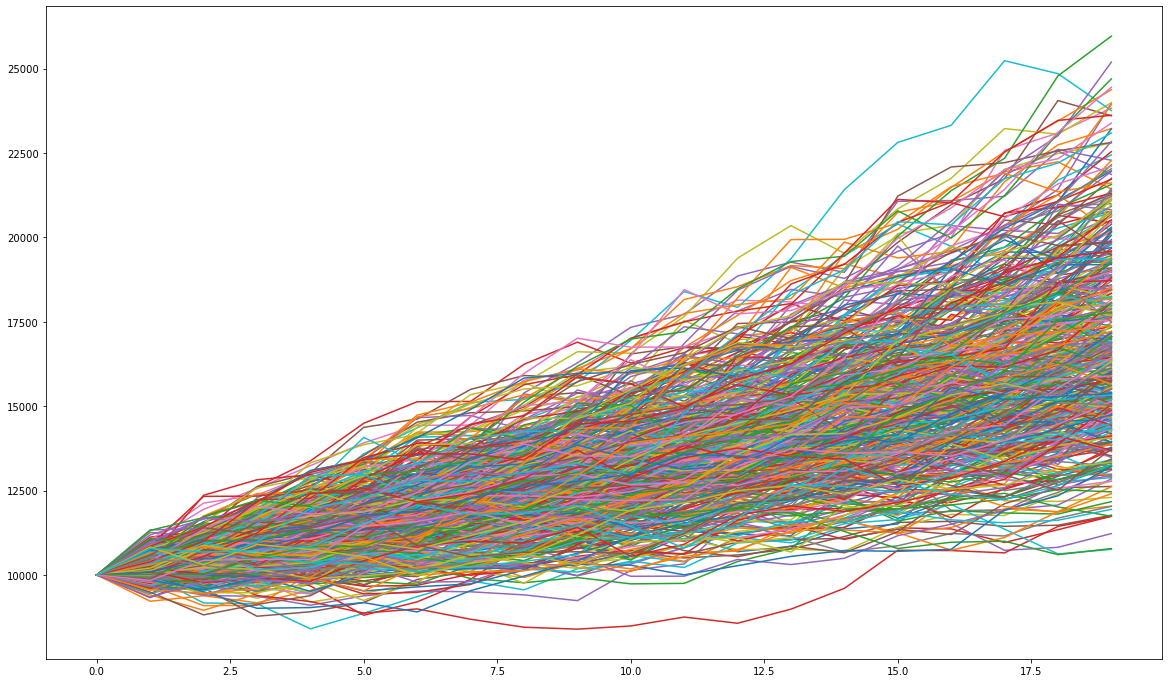

In [29]:
#plot the results. Ideally we could simply use this function to allow easily interchangable parameters 
simulate_return(annual_ret,annual_std,annual_income,simulated_quarters,500,investment_value).plot(figsize = (20,12), legend=None)

In [30]:
# Creates a new variable for the end results of the simulation
ending_values = simulate_return(annual_ret,annual_std,annual_income,simulated_quarters,500,investment_value).tail(1)

In [31]:
# Organizes ending results into one column
ending_values = ending_values.T
ending_values.columns = ['Ending Values']
ending_values

,Ending Values
0,17704.262562
1,19665.683420
2,14323.988420
3,20480.780470
4,16233.783223
...,...
495,17332.827969
496,16383.514066
497,14224.810443
498,15399.343740


<AxesSubplot:ylabel='Frequency'>

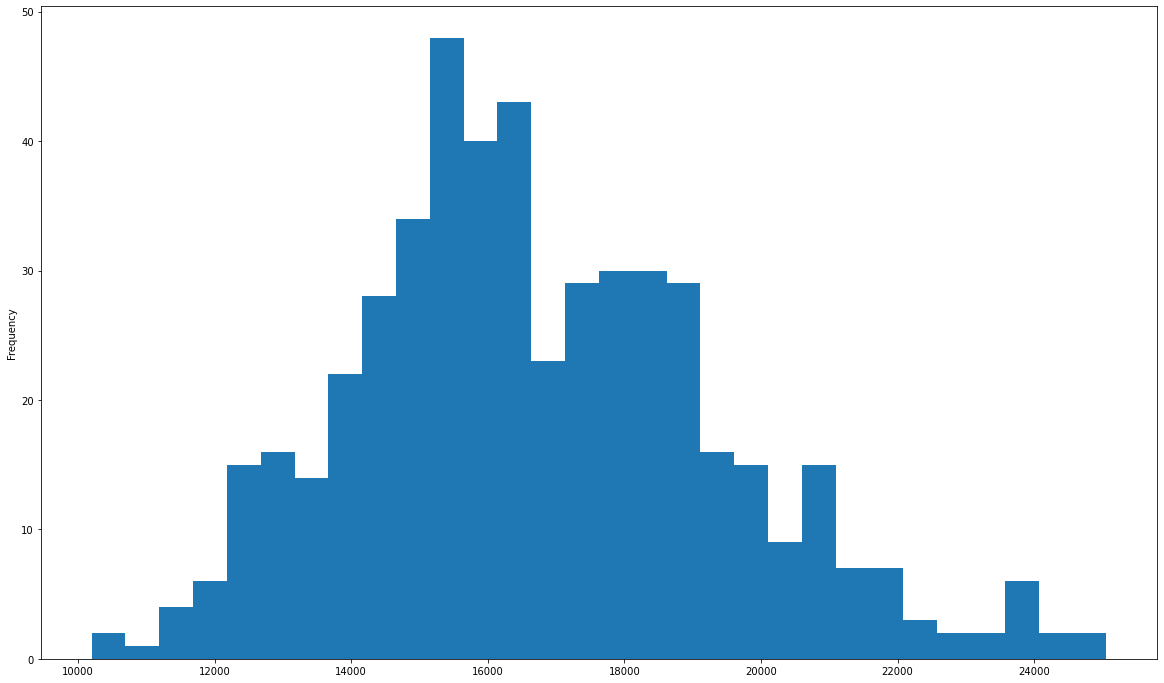

In [32]:
# Plots distribution of ending results
ending_values.plot.hist(bins = 30, figsize = (20,12), legend=None)

In [33]:
# See summary statistics for ending results
ending_values.describe()

,Ending Values
count,500.000000
mean,16713.240344
std,2686.891729
min,10199.768688
25%,14929.677655
50%,16314.873314
75%,18466.615726
max,25055.191598
